# Chapter 1b: Temporal Quality Assessment (Event Bronze Track)

**Purpose:** Run quality checks specific to event-level datasets to identify data issues before feature engineering.

**When to use this notebook:**
- After completing 01a_temporal_deep_dive.ipynb
- Your dataset is EVENT_LEVEL granularity
- You want to validate temporal data integrity before aggregation

| Check | What It Detects | Why It Matters for ML |
|-------|-----------------|----------------------|
| **TQ001** | Duplicate events (same entity + timestamp) | Inflates counts, skews aggregations, creates artificial sequence patterns |
| **TQ002** | Unexpected temporal gaps | Rolling features become misleading; "events in last 30d" drops during gaps |
| **TQ003** | Future dates | Data leakage — model sees future during training |
| **TQ004** | Ambiguous event ordering | Sequence features undefined when multiple events share timestamp |

## 1b.1 Load Findings and Data

In [1]:
from pathlib import Path
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from customer_retention.analysis.auto_explorer import ExplorationFindings, RecommendationEngine
from customer_retention.analysis.visualization import ChartBuilder, display_figure
from customer_retention.core.config.column_config import ColumnType
from customer_retention.stages.profiling import (
    DuplicateEventCheck, TemporalGapCheck, FutureDateCheck, EventOrderCheck,
    TemporalQualityReporter, SegmentAwareOutlierAnalyzer
)
from customer_retention.stages.temporal import load_data_with_snapshot_preference, TEMPORAL_METADATA_COLS
from customer_retention.core.config.experiments import FINDINGS_DIR, EXPERIMENTS_DIR, OUTPUT_DIR, setup_experiments_structure


In [2]:
# FINDINGS_DIR imported from customer_retention.core.config.experiments
findings_files = sorted(
    [f for f in FINDINGS_DIR.glob("*_findings.yaml") if "multi_dataset" not in f.name],
    key=lambda f: f.stat().st_mtime, reverse=True
)
if not findings_files:
    raise FileNotFoundError(f"No findings in {FINDINGS_DIR}. Run notebook 01 first.")

FINDINGS_PATH = str(findings_files[0])
findings = ExplorationFindings.load(FINDINGS_PATH)
print(f"Using: {FINDINGS_PATH}")

ts_meta = findings.time_series_metadata
ENTITY_COLUMN, TIME_COLUMN = ts_meta.entity_column, ts_meta.time_column
print(f"Entity: {ENTITY_COLUMN}, Time: {TIME_COLUMN}")

df, data_source = load_data_with_snapshot_preference(findings, output_dir=str(FINDINGS_DIR))
charts = ChartBuilder()
print(f"Loaded {len(df):,} rows ({data_source})")

Using: /Users/Vital/python/CustomerRetention/experiments/findings/customer_emails_408768_findings.yaml
Entity: customer_id, Time: feature_timestamp
Loaded 74,842 rows (snapshot)


## 1b.2 Configure Quality Checks

In [3]:
REFERENCE_DATE = pd.Timestamp.now()  # or pd.Timestamp("2024-01-01")
EXPECTED_FREQUENCY = "D"  # D=daily, W=weekly, M=monthly, H=hourly
MAX_GAP_MULTIPLE = 3.0

print(f"Reference: {REFERENCE_DATE.date()}, Frequency: {EXPECTED_FREQUENCY}, Gap threshold: {MAX_GAP_MULTIPLE}x")

Reference: 2026-01-29, Frequency: D, Gap threshold: 3.0x


## 1b.3 Run Temporal Quality Checks

| Issue Type | ML Impact | Mitigation |
|------------|-----------|------------|
| Duplicates | Sum/count features inflated; artificial patterns in sequences | Deduplicate or add sequence index |
| Gaps | Rolling aggregations drop; recency features spike | Document gaps; add gap indicator feature |
| Future dates | Model trains on leaked future info | Filter to reference date; check timezone handling |
| Ordering | "Previous event" features undefined | Add tiebreaker column; use stable sort |

In [4]:
checks = [
    DuplicateEventCheck(entity_column=ENTITY_COLUMN, time_column=TIME_COLUMN),
    TemporalGapCheck(time_column=TIME_COLUMN, expected_frequency=EXPECTED_FREQUENCY, max_gap_multiple=MAX_GAP_MULTIPLE),
    FutureDateCheck(time_column=TIME_COLUMN, reference_date=REFERENCE_DATE),
    EventOrderCheck(entity_column=ENTITY_COLUMN, time_column=TIME_COLUMN),
]
results = [check.run(df) for check in checks]
reporter = TemporalQualityReporter(results, len(df))
reporter.print_results()

TEMPORAL QUALITY CHECK RESULTS

📋 Summary: 3/4 checks passed

❌ [TQ001] Duplicate Events
   🟠 Severity: medium | Found 371 duplicate events (same entity + timestamp)

   📊 Impact (371 issues = 0.50%):
      • Event counts: Inflated metrics
      • Aggregations: Skewed
      • Sequences: Artificial patterns
   🛠️ Fix: df.drop_duplicates(subset=[entity, time], keep='first')

✅ [TQ002] Temporal Gaps
   🔵 Severity: info | No significant temporal gaps detected

✅ [TQ003] Future Dates
   🔵 Severity: info | No future dates detected

✅ [TQ004] Event Ordering
   🟡 Severity: low | 371 events have ambiguous ordering (same timestamp)

   📊 Impact (371 issues = 0.50%):
      • Sequences: Undefined order
      • State tracking: Ambiguous
      • Lags: Unclear
   🛠️ Fix: Add sequence: df['seq'] = df.groupby(entity).cumcount()



## 1b.4 Quality Score

| Component | Weight | Scoring Logic |
|-----------|--------|---------------|
| Each check | 25% | 100 if no issues; deductions proportional to % affected |
| Grade A | 90-100 | Proceed with confidence |
| Grade B | 75-89 | Document issues, proceed with caution |
| Grade C | 60-74 | Address issues before feature engineering |
| Grade D | <60 | Investigation required |

In [5]:
reporter.print_score()
quality_score, grade, passed = reporter.quality_score, reporter.grade, reporter.passed


QUALITY SCORE: 96/100  🏆 Grade A

  Total: [██████████████████████████████████████░░] 96%

  △ Duplicate Events   [██████████████████░░] 23.1/25  (371 issues)
  ✓ Temporal Gaps      [████████████████████] 25.0/25  (no issues)
  ✓ Future Dates       [████████████████████] 25.0/25  (no issues)
  △ Event Ordering     [██████████████████░░] 23.1/25  (371 issues)

  Grade A: Excellent - ready for feature engineering


## 1b.5 Event Volume Analysis

| What to Look For | Indicates | Action |
|-----------------|-----------|--------|
| Missing bars | Data gaps (TQ002) | Document; add gap indicator |
| Declining trend | Population shrinkage or data cutoff | Check if intentional |
| Spikes | Campaigns, seasonality, or data issues | Investigate cause |
| Flat periods | Possible logging outages | Verify with data source |

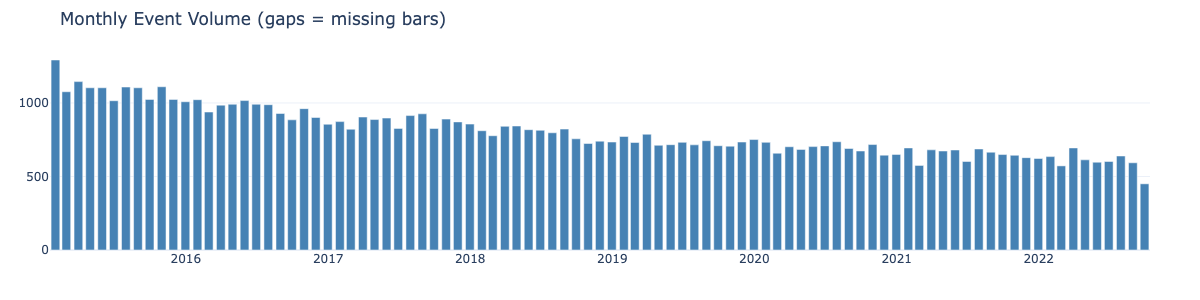

In [6]:
df_temp = df.copy()
df_temp[TIME_COLUMN] = pd.to_datetime(df_temp[TIME_COLUMN])
time_span = (df_temp[TIME_COLUMN].max() - df_temp[TIME_COLUMN].min()).days

freq, label = ("D", "Daily") if time_span <= 90 else ("W", "Weekly") if time_span <= 365 else ("ME", "Monthly")
counts = df_temp.groupby(pd.Grouper(key=TIME_COLUMN, freq=freq)).size()

fig = go.Figure(go.Bar(x=counts.index, y=counts.values, marker_color="#4682B4"))
fig.update_layout(title=f"{label} Event Volume (gaps = missing bars)", height=300, template="plotly_white")
display_figure(fig)

## 1b.6 Outlier Analysis

| Approach | When to Use | Why It Matters |
|----------|-------------|----------------|
| Global detection | Homogeneous data | Simple threshold works |
| Segment-aware | Data has natural groups | Avoids false positives when segments have different scales |

Segment-aware detection clusters entities by target (or other segment) and detects outliers within each group separately.

In [7]:
numeric_cols = [n for n, c in findings.columns.items()
    if c.inferred_type in [ColumnType.NUMERIC_CONTINUOUS, ColumnType.NUMERIC_DISCRETE]
    and n not in [ENTITY_COLUMN, TIME_COLUMN] and n not in TEMPORAL_METADATA_COLS]

if numeric_cols:
    analyzer = SegmentAwareOutlierAnalyzer(max_segments=5)
    result = analyzer.analyze(df, feature_cols=numeric_cols, segment_col=None, target_col=findings.target_column)
    
    print(f"Segments detected: {result.n_segments}")
    if result.n_segments > 1:
        data = [{"Feature": c, "Global": result.global_analysis[c].outliers_detected,
            "Segment": sum(s[c].outliers_detected for s in result.segment_analysis.values() if c in s)}
            for c in numeric_cols]
        display(pd.DataFrame(data))
        if result.segmentation_recommended:
            print("\n💡 Segment-specific outlier treatment recommended")
    else:
        print("Data appears homogeneous - using global outlier detection")
else:
    print("No numeric columns for outlier analysis.")

Segments detected: 3


,Feature,Global,Segment
0,send_hour,0,0
1,time_to_open_hours,824,183



💡 Segment-specific outlier treatment recommended


## 1b.7 Data Validation

| Check | Issue | Impact |
|-------|-------|--------|
| Binary fields | Values outside {0, 1} | Model crashes or silent errors |
| String consistency | Case/spacing variants ("Yes" vs "yes") | Inflated cardinality; split categories |
| Missing patterns | Systematic missingness | Bias in imputation |

In [8]:
# Binary field validation
binary_cols = [n for n, c in findings.columns.items() if c.inferred_type == ColumnType.BINARY and n not in TEMPORAL_METADATA_COLS]
for col in binary_cols:
    c0, c1 = (df[col] == 0).sum(), (df[col] == 1).sum()
    print(f"✓ {col}: 0={c0:,} ({c0/(c0+c1)*100:.1f}%), 1={c1:,} ({c1/(c0+c1)*100:.1f}%)")

# Consistency check
issues = []
for col in df.select_dtypes(include=['object']).columns:
    if col in [ENTITY_COLUMN, TIME_COLUMN]: continue
    variants = {}
    for v in df[col].dropna().unique():
        key = str(v).lower().strip()
        variants.setdefault(key, []).append(v)
    issues.extend([{"Column": col, "Variants": vs} for vs in variants.values() if len(vs) > 1])

print(f"\n{'⚠️ Consistency issues: ' + str(len(issues)) if issues else '✅ No consistency issues'}")

✓ opened: 0=58,167 (77.7%), 1=16,675 (22.3%)
✓ clicked: 0=69,758 (93.2%), 1=5,084 (6.8%)
✓ bounced: 0=73,238 (97.9%), 1=1,604 (2.1%)

✅ No consistency issues


## 1b.8 Recommendations

Framework-generated recommendations based on column-level issues detected during exploration.

In [9]:
rec_engine = RecommendationEngine()
recs = rec_engine.recommend_cleaning(findings)

if recs:
    for r in sorted(recs, key=lambda x: {"high": 0, "medium": 1, "low": 2}.get(x.severity, 3)):
        icon = {"high": "🔴", "medium": "🟡", "low": "🟢"}.get(r.severity, "⚪")
        print(f"{icon} [{r.severity.upper()}] {r.column_name}: {r.description}")
        label = r.strategy_label if r.strategy_label else r.strategy.replace("_", " ").title()
        print(f"   Strategy: {label}")
else:
    print("✅ No critical cleaning recommendations")

🔴 [HIGH] time_to_open_hours: 77.7% missing values (critical)
   Strategy: Drop Column or Create Missing Indicator
🔴 [HIGH] unsubscribe_date: 97.4% missing values (critical)
   Strategy: Drop Column or Create Missing Indicator


## 1b.9 Save Results

In [10]:
if not findings.metadata:
    findings.metadata = {}
findings.metadata["temporal_quality"] = reporter.to_dict()
findings.save(FINDINGS_PATH)
print(f"Saved to: {FINDINGS_PATH}")
print(f"Score: {quality_score:.0f}/100 (Grade {grade})")

Saved to: /Users/Vital/python/CustomerRetention/experiments/findings/customer_emails_408768_findings.yaml
Score: 96/100 (Grade A)


---

## Summary: What We Learned

In this notebook, we validated temporal data quality:

1. **Temporal Quality Checks** — Detected duplicates, gaps, future dates, ordering issues
2. **Quality Score** — Quantified overall data health with pass/fail grading
3. **Event Volume** — Visualized data coverage over time
4. **Outlier Analysis** — Compared global vs segment-aware detection
5. **Data Validation** — Verified binary fields and string consistency

## Quality Score Interpretation

| Grade | Score | Meaning | Action |
|-------|-------|---------|--------|
| A | 90-100 | Excellent | Proceed with confidence |
| B | 75-89 | Good | Document issues, proceed |
| C | 60-74 | Fair | Address issues before aggregation |
| D | <60 | Poor | Investigation required |

---

## Next Steps

Continue with the **Event Bronze Track**:

1. **01c_temporal_patterns.ipynb** — Detect trends, seasonality, cohort effects
2. **01d_event_aggregation.ipynb** — Aggregate events to entity-level features

After 01d, continue with **Entity Bronze Track** (02 → 03 → 04) on aggregated data.